In [33]:
from numpy import *
import matplotlib.pyplot as plt
import numba as nb
%load_ext line_profiler
%matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

@nb.njit
def seed(x):
    random.seed(x)

# Исходный

In [378]:
%%time
@nb.njit('(int8[:, ::1], float64[::1], int64, int64, float64, float64)')
def calc_model_nb(x, T_level, n_iterations, window, J, h):
    k_Boltzmann = 1

    n_side, n_side = x.shape
    n_particles = n_side * n_side
    n_levels, = T_level.shape

    x_tr = empty((n_side, n_side))
    E_level = empty(n_levels)
    C_level = empty(n_levels)
    M_level = empty(n_levels)
    E = empty(n_iterations)
    M = empty(n_iterations)

    for l in range(n_levels):
        T = T_level[l]

        for k in range(n_iterations):
            i = random.randint(n_side)
            j = random.randint(n_side)

            x_tr[:] = x
            x_tr[i, j] = - x_tr[i, j]
            
            E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
            E_tr = - J * ((x_tr[:-1, 1:] + x_tr[1:, :-1]) * x_tr[:-1, :-1]).sum() - h * x_tr.sum()

            dE = E_tr - E0

            if dE <= 0:
                x[:] = x_tr
            else:
                R = exp(- dE / k_Boltzmann / T)
                r = random.rand()

                if r <= R:
                    x[:] = x_tr

            E[k] = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
            M[k] = x.sum() / n_particles

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE / n_particles
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM

    return x, E_level, C_level, M_level

CPU times: user 3.25 s, sys: 3.18 ms, total: 3.26 s
Wall time: 3.28 s


In [207]:
seed(1)

# ----------
n_side = 20
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
# x = random.randint(2, size=(n_side, n_side)) * 2 - 1  # hot
x = full((n_side, n_side), 1, 'int8')  # cold

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
x, E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)
# %lprun -f calc_model_nb calc_model_nb(x, T, n_step, window, J, h)
# x, E, C, M = calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 1.37 s


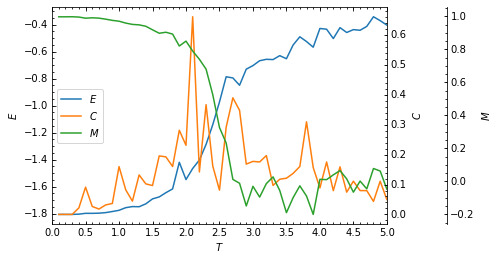

In [208]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

# Оптимизированный в три раза от исходного

In [437]:
%%time
@nb.njit('(int8[:, ::1], float64[::1], int64, int64, float64, float64)')
def calc_model_nb(x, T_level, n_iterations, window, J, h):
    k_Boltzmann = 1
    x = x.copy()

    n_side, n_side = x.shape
    n_particles = n_side * n_side
    n_levels, = T_level.shape

    E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
    M0 = x.sum() / n_particles

    E_level = empty(n_levels)
    C_level = empty(n_levels)
    M_level = empty(n_levels)
    E = empty(n_iterations)
    M = empty(n_iterations)

    for l in range(n_levels):
        T = T_level[l]

        for k in range(n_iterations):
            i = random.randint(n_side)
            j = random.randint(n_side)

            x[i, j] = - x[i, j]
            E_tr = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()

            dE = E_tr - E0

            if dE <= 0:
                E0 = E_tr
                M0 = x.sum() / n_particles
            else:
                R = exp(- dE / k_Boltzmann / T)
                r = random.rand()

                if r <= R:
                    E0 = E_tr
                    M0 = x.sum() / n_particles
                else:
                    x[i, j] = - x[i, j]

            E[k] = E0
            M[k] = M0

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE / n_particles
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM

    return x, E_level, C_level, M_level

CPU times: user 1.49 s, sys: 3.94 ms, total: 1.49 s
Wall time: 1.49 s


In [361]:
seed(1)

# ----------
n_side = 20
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
# x = random.randint(2, size=(n_side, n_side)) * 2 - 1  # hot
x = full((n_side, n_side), 1, 'int8')  # cold

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
x, E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)
# %lprun -f calc_model_nb calc_model_nb(x, T, n_step, window, J, h)
# x, E, C, M = calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 366 ms, sys: 3.5 ms, total: 370 ms
Wall time: 369 ms


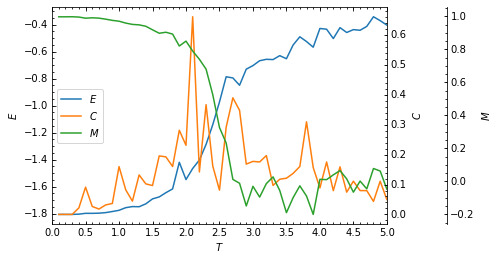

In [362]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

# С формулой для ускорения

In [436]:
%%time
@nb.njit('(int8[:, ::1], float64[::1], int64, int64, float64, float64)')
def calc_model_boosted_nb(x, T_level, n_iterations, window, J, h):
    k_Boltzmann = 1
    x = x.copy()

    n_side, n_side = x.shape
    n_particles = n_side * n_side
    n_levels, = T_level.shape

    E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
    M0 = x.sum() / n_particles

    E_level = empty(n_levels)
    C_level = empty(n_levels)
    M_level = empty(n_levels)
    E = empty(n_iterations)
    M = empty(n_iterations)
    E[-1] = E0
    M[-1] = M0

    # добавить рамку с шириной 1 со значениями 0
#     x = pad(x, 1)
    x_ = zeros((n_side + 2, n_side + 2), 'int8')
    x_[1:-1, 1:-1] = x
    x = x_

    for l in range(n_levels):
        T = T_level[l]

        for k in range(n_iterations):
            i = random.randint(n_side) + 1
            j = random.randint(n_side) + 1

            dE = 2 * J * (x[i - 1, j] + x[i, j - 1] + x[i + 1, j] + x[i, j + 1]) * x[i, j] + 2 * h * x[i, j]
            dM = 0

            if dE <= 0:
                dM = - 2 * x[i, j] / n_particles
                x[i, j] = - x[i, j]
            else:
                R = exp(- dE / k_Boltzmann / T)
                r = random.rand()

                if r <= R:
                    dM = - 2 * x[i, j] / n_particles
                    x[i, j] = - x[i, j]
                else:
                    dE = 0

            E[k] = E[k - 1] + dE
            M[k] = M[k - 1] + dM

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE / n_particles
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM
    
    # убрать рамку
    x = x[1:-1, 1:-1]

    return x, E_level, C_level, M_level

CPU times: user 2.19 s, sys: 4.84 ms, total: 2.2 s
Wall time: 2.21 s


In [288]:
seed(1)

# ----------
n_side = 20
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
# x = random.randint(2, size=(n_side, n_side)) * 2 - 1  # hot
x = full((n_side, n_side), 1, 'int8')  # cold

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
# x, E, C, M = %time calc_model_boosted_nb(x, T, n_step, window, J, h)
x, E, C, M = calc_model_boosted_nb(x, T, n_step, window, J, h)

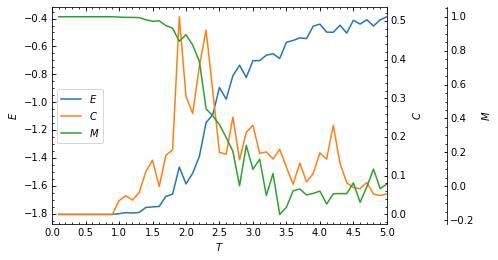

In [289]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

In [359]:
random.seed(0)
n = 5
x0 = random.randint(2, size=(n, n)) * 2 - 1  # hot
# x0 = full((n, n), 1, 'int8')  # cold
x1 = pad(x0, 1)
dE0 = empty((n, n))
dE1 = empty((n, n))

for i in range(n):
    for j in range(n):
        x = x0

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]

        E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
        E_tr = - J * ((x_tr[:-1, 1:] + x_tr[1:, :-1]) * x_tr[:-1, :-1]).sum() - h * x_tr.sum()
        dE0[i, j] = E_tr - E0


        x = x1

        dE1[i, j] = (lambda i, j: 2 * J * (x[i - 1, j] + x[i, j - 1] + x[i + 1, j] + x[i, j + 1]) * x[i, j] + 2 * h * x[i, j])(i + 1, j + 1)

display(dE0 - dE1)

array([[ 0.,  0.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  0.,  4.],
       [ 2.,  0.,  0.,  0.,  0.]])

In [359]:
random.seed(0)
n = 5
x0 = random.randint(2, size=(n, n)) * 2 - 1  # hot
# x0 = full((n, n), 1, 'int8')  # cold
x1 = pad(x0, 1)
dE0 = empty((n, n))
dE1 = empty((n, n))

for i in range(n):
    for j in range(n):
        x = x0

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]

        E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
        E_tr = - J * ((x_tr[:-1, 1:] + x_tr[1:, :-1]) * x_tr[:-1, :-1]).sum() - h * x_tr.sum()
        dE0[i, j] = E_tr - E0


        x = x1

        dE1[i, j] = (lambda i, j: 2 * J * (x[i - 1, j] + x[i, j - 1] + x[i + 1, j] + x[i, j + 1]) * x[i, j] + 2 * h * x[i, j])(i + 1, j + 1)

display(dE0 - dE1)

array([[ 0.,  0.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  0.,  4.],
       [ 2.,  0.,  0.,  0.,  0.]])

https://medium.com/geekculture/interactive-animated-visualization-using-animatplot-fb420f2a89a7

In [509]:
import numpy as np
# Define LxL matrix
L = 55
# Initialize as random spin
M = 2*(np.random.rand(L,L)>.5)-1
J = 1
b = 2.5

nPer = 100

images = [M]
for i in range(100):
    M = M.copy()
    for dm in range(nPer):
        jj = int(np.random.rand()*L - 1)
        kk = int(np.random.rand()*L - 1)
        dE = 2*J*(M[jj+1,kk] + M[jj-1,kk] + M[jj,kk+1] + M[jj,kk-1])*M[jj,kk]
        if dE <= 0:
            M[jj,kk]*=-1
        else:
            if(np.random.rand()<np.exp(-b*dE)):
                M[jj,kk]*=-1
    images.append(M)
    M[:,-1] = M[:,0]
    M[-1,:] = M[0,:]

In [511]:
jj = int(np.random.rand()*L - 1)
kk = int(np.random.rand()*L - 1)
jj = L - 1
dE = 2*J*(M[jj+1,kk] + M[jj-1,kk] + M[jj,kk+1] + M[jj,kk-1])*M[jj,kk]

IndexError: index 55 is out of bounds for axis 0 with size 55

In [529]:
int(1*L - 1)

54

In [5]:
from numpy import *
J = 1
h = 0

random.seed(0)
n = 5
# x0 = random.randint(2, size=(n, n)) * 2 - 1  # hot
x0 = full((n, n), 1, 'int8')  # cold
x1 = pad(x0, 1)
dE0 = empty((n, n))
dE1 = empty((n, n))

for i in range(n):
    for j in range(n):
        x = x0

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]

        E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
        E_tr = - J * ((x_tr[:-1, 1:] + x_tr[1:, :-1]) * x_tr[:-1, :-1]).sum() - h * x_tr.sum()
        dE0[i, j] = E_tr - E0

        
        i += 1; j += 1

        x = x1

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]

        E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
        E_tr = - J * ((x_tr[:-1, 1:] + x_tr[1:, :-1]) * x_tr[:-1, :-1]).sum() - h * x_tr.sum()
        
        i -= 1; j -= 1
        dE1[i, j] = E_tr - E0

display(dE0 - dE1)

array([[ 0.,  0.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0., -4.],
       [ 0.,  0.,  0.,  0., -4.],
       [ 0.,  0.,  0.,  0., -4.],
       [-2., -4., -4., -4., -4.]])

In [44]:
from numpy import *
J = 1
h = 0

random.seed(0)
n = 5
# x0 = random.randint(2, size=(n, n)) * 2 - 1  # hot
x0 = full((n, n), 1, 'int8')  # cold
dE0 = empty((n, n))
dE1 = empty((n, n))

for i in range(n):
    for j in range(n):
        x = x0.copy()

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]
        
        def calc_E(x):
            n, n = x.shape
            s0 = 0
            for i in range(n - 1):
                for j in range(n - 1):
                    s0 += x[i + 1, j] * x[i, j] + x[i, j + 1] * x[i, j]
            
            i, j = n - 1, n - 1
            s0 += x[i - 1, j] * x[i, j] + x[i, j - 1] * x[i, j]

            s1 = 0
            for i in range(n):
                for j in range(n):
                    s1 += x[i, j]
            
            E = - J * s0 - h * s1
            
            return E
        
        dE0[i, j] = calc_E(x_tr) - calc_E(x)

        
        x = x0.copy()

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]
        
        x = pad(x, 1)[1:, 1:]
        x_tr = pad(x_tr, 1)[1:, 1:]

        E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
        E_tr = - J * ((x_tr[:-1, 1:] + x_tr[1:, :-1]) * x_tr[:-1, :-1]).sum() - h * x_tr.sum()
        dE1[i, j] = E_tr - E0

display(dE0 - dE1)

array([[ 0.,  0.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0., -4.],
       [ 0.,  0.,  0.,  0., -4.],
       [ 0.,  0.,  0.,  0., -2.],
       [-2., -4., -4., -2.,  0.]])

In [78]:
from numpy import *
J = 1
h = 0

# random.seed(0)
n = 5
# x0 = random.randint(2, size=(n, n)) * 2 - 1  # hot
x0 = full((n, n), 1, 'int8')  # cold
dE0 = empty((n, n), 'int8')
dE1 = empty((n, n), 'int8')

for i in range(n):
    for j in range(n):
        x = x0.copy()

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]
        
        def calc_E(x):
            n, n = x.shape
            s0 = 0
            for i in range(n - 1):
                for j in range(n - 1):
                    s0 += x[i + 1, j] * x[i, j] + x[i, j + 1] * x[i, j]
            
            i, j = n - 1, n - 1
            s0 += x[i - 1, j] * x[i, j] + x[i, j - 1] * x[i, j]

            s1 = 0
            for i in range(n):
                for j in range(n):
                    s1 += x[i, j]
            
            E = - J * s0 - h * s1
            
            return E
        
        dE0[i, j] = calc_E(x_tr) - calc_E(x)

        
        x = x0.copy()

        x_tr = x.copy()
        x_tr[i, j] = - x_tr[i, j]
        
        x = pad(x, 1)[1:, 1:]
        x_tr = pad(x_tr, 1)[1:, 1:]
        
        def calc_E(x):
            n, n = x.shape
            s0 = 0
            for i in range(n - 1):
                for j in range(n - 1):
                    s0 += x[i + 1, j] * x[i, j] + x[i, j + 1] * x[i, j]

            s1 = 0
            for i in range(n):
                for j in range(n):
                    s1 += x[i, j]
            
            E = - J * s0 - h * s1
            
            return E
        
        dE1[i, j] = calc_E(x_tr) - calc_E(x)

display(dE0 - dE1)

array([[ 0,  0,  0,  0, -2],
       [ 0,  0,  0,  0, -4],
       [ 0,  0,  0,  0, -4],
       [ 0,  0,  0,  0, -2],
       [-2, -4, -4, -2,  0]], dtype=int8)

In [77]:
display(dE0, dE1)

array([[4., 6., 6., 6., 2.],
       [6., 8., 8., 8., 2.],
       [6., 8., 8., 8., 2.],
       [6., 8., 8., 8., 4.],
       [2., 2., 2., 4., 4.]])

array([[4., 6., 6., 6., 4.],
       [6., 8., 8., 8., 6.],
       [6., 8., 8., 8., 6.],
       [6., 8., 8., 8., 6.],
       [4., 6., 6., 6., 4.]])

In [36]:
x[:-1, 1:]

array([[1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0]], dtype=int8)